# Multiple output CNN

This notebook shows how to write CNN with multiple outputs with Keras.
There are many circumstances where you recognize one thing with multiple names.
A cat is a cat, as well as mammal and animal.
An airplane is an artifact and flying object.
This notebook trains a neural network model to predict one thing with four labels, allowing you to get output of four description on your image.
For image dataset, I use Cifar10, with 3 sets of label added.
- Additional label1: artifact and animal
- Additional label2: car, mammal, fly and water
- Additional label3: dark image or bright image

## Prerequisite

In [57]:
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import os
import copy
import matplotlib.pyplot as plt

In [36]:
# make saving directory
saveDir = "./multi3cifar10/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [38]:
batch_size = 50
num_classes1 = 10
num_classes2 = 2
num_classes3 = 4
num_classes4 = 2
epochs = 100

## prepare dataset

In [39]:
# load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [40]:
# prepare x dataset
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

### defining new label groups for label2, label3 and label4

In [63]:
# give a name to each label
label1 = {0:"airplane",
          1:"automobile",
          2:"bird",
          3:"cat",
          4:"deer",
          5:"dog",
          6:"frog",
          7:"horse",
          8:"ship",
          9:"truck"}
label2 = {0:"artifact", #0,1,8,9
          1:"animal"} #2,3,4,5,6,7
label3 = {0:"car", #1,9
          1:"mammal", #3,4,5,7
          2:"fly", #0,2
          3:"water"} #6,8
label4 = {0:"dark", #if average pixel is below 128
          1:"bright"} #if average pixel is over 128

In [42]:
# defining y_train2 and y_test2, with inorganic objects as 0 and organic objects as 1
def modLabel2(y):
    y2 = copy.deepcopy(y)
    for i in range(len(y)):
        if y2[i] in [0,1,8,9]:
            y2[i] = 0
        else:
            y2[i] = 1
    return y2
y_train2 = modLabel2(y_train)
y_test2 = modLabel2(y_test)

In [43]:
# defining y_train3 and y_test3 with 4 labels
def modLabel3(y):
    y3 = copy.deepcopy(y)
    for i in range(len(y)):
        if y3[i] in [1,9]:
            y3[i] = 0
        elif y3[i] in [3,4,5,7]:
            y3[i] = 1
        elif y3[i] in [0,2]:
            y3[i] = 2
        else:
            y3[i] = 3
    return y3
y_train3 = modLabel3(y_train)
y_test3 = modLabel3(y_test)

In [44]:
# defining y_train3 and y_test4 with 2 labels
def genLabel4(x):
    y4 = []
    for i in range(len(x)):
        brightness = np.average(x[i].ravel())
        if brightness < 0.5:
            y4.append([0])
        elif brightness >= 0.5:
            y4.append([1])
    return np.array(y4)
y_train4 = genLabel4(x_train)
y_test4 = genLabel4(x_test)

### convert each target labels to binary class matrices

In [45]:
# Convert class vectors to binary class matrices.
y_train1 = keras.utils.to_categorical(y_train, num_classes1)
y_test1 = keras.utils.to_categorical(y_test, num_classes1)

y_train2 = keras.utils.to_categorical(y_train2, num_classes2)
y_test2 = keras.utils.to_categorical(y_test2, num_classes2)

y_train3 = keras.utils.to_categorical(y_train3, num_classes3)
y_test3 = keras.utils.to_categorical(y_test3, num_classes3)

y_train4 = keras.utils.to_categorical(y_train4, num_classes4)
y_test4 = keras.utils.to_categorical(y_test4, num_classes4)

print("y train1:{0}\ny test1:{1}\ny train2:{2}\ny test2:{3}\ny train3:{4}\ny test3:{5}\ny train4:{6}\ny test4:{7}".format(
    y_train1.shape, y_test1.shape, y_train2.shape, y_test2.shape, y_train3.shape, y_test3.shape, y_train4.shape, y_test4.shape))

y train1:(50000, 10)
y test1:(10000, 10)
y train2:(50000, 2)
y test2:(10000, 2)
y train3:(50000, 4)
y test3:(10000, 4)
y train4:(50000, 2)
y test4:(10000, 2)


### image, label1, label2, label3 and label4

data0 is frog, animal, water and dark


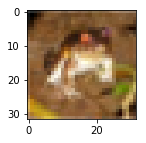

data1 is truck, artifact, car and bright


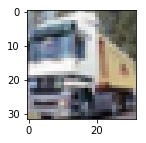

data2 is truck, artifact, car and bright


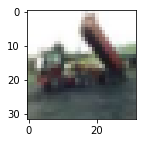

data3 is deer, animal, mammal and dark


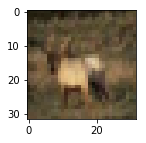

data4 is automobile, artifact, car and dark


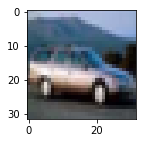

data5 is automobile, artifact, car and dark


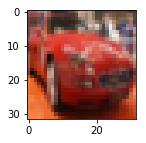

data6 is bird, animal, fly and dark


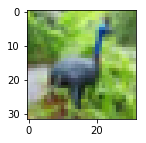

data7 is horse, animal, mammal and dark


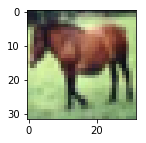

data8 is ship, artifact, water and bright


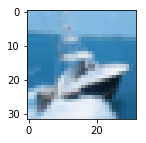

data9 is cat, animal, mammal and dark


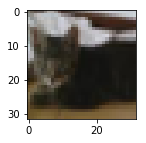

In [68]:
for i in range(10):
    plt.figure(figsize=(2, 2))
    print("data{0} is {1}, {2}, {3} and {4}".format(
        i,label1[np.argmax(y_train1[i])], label2[np.argmax(y_train2[i])], label3[np.argmax(y_train3[i])], label4[np.argmax(y_train4[i])]))
    plt.imshow(x_train[i].reshape(32, 32, 3))
    plt.show()

## Neural network

In [48]:
# input layer
cifarInput = Input(shape=(x_train.shape[1:]))

# convolution and max pooling layers
x = Conv2D(32, (3, 3), padding='same', activation='relu')(cifarInput)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

# classification layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
# original labels, 0 to 9, as output1
output1 = Dense(num_classes1, activation='softmax', name='output1')(x)
# second labels, 0 or 1, as output2
output2 = Dense(num_classes2, activation='softmax', name='output2')(x)
# third labels, 0 to 3, as output3
output3 = Dense(num_classes3, activation='softmax', name='output3')(x)
# fourth labels, 0 or 1, as output4
output4 = Dense(num_classes4, activation='softmax', name='output4')(x)

multiModel = Model(cifarInput, [output1, output2, output3, output4])

In [49]:
# initiate Adam optimizer
opt = keras.optimizers.adam(lr=0.0001, decay=1e-6)

# Let's train the model using Adam
multiModel.compile(loss={'output1': 'categorical_crossentropy',
                         'output2': 'categorical_crossentropy',
                         'output3': 'categorical_crossentropy',
                         'output4': 'categorical_crossentropy'},
                   optimizer=opt,
                   metrics=['accuracy'])

In [50]:
# get the newest model file
def getNewestModel(model, dirname=saveDir):
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return model
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        model.load_weights(newestModel[0])
        return model
multiModel = getNewestModel(multiModel, saveDir)

In [51]:
# early stopping and model checkpoint
es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = os.path.join(saveDir, 'MultiCifar10_.{epoch:02d}-{val_loss:.2f}-{val_output1_loss:.2f}-{val_output2_loss:.2f}-{val_output3_loss:.2f}-{val_output4_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

## train one neural network with four targets at once

In [52]:
# train model
history = multiModel.fit(x_train,
                         {'output1': y_train1,
                          'output2': y_train2,
                          'output3': y_train3,
                          'output4': y_train4},
                         batch_size=batch_size,
                         epochs=epochs,
                         validation_data=(x_test, 
                                          {'output1': y_test1,
                                           'output2': y_test2,
                                           'output3': y_test3,
                                           'output4': y_test4}),
                         callbacks=[es_cb, cp_cb])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 105s 2ms/step - loss: 3.5578 - output1_loss: 1.8337 - output2_loss: 0.3721 - output3_loss: 1.0492 - output4_loss: 0.3028 - output1_acc: 0.3230 - output2_acc: 0.8332 - output3_acc: 0.5625 - output4_acc: 0.8625 - val_loss: 2.7786 - val_output1_loss: 1.5212 - val_output2_loss: 0.2497 - val_output3_loss: 0.8540 - val_output4_loss: 0.1536 - val_output1_acc: 0.4479 - val_output2_acc: 0.8989 - val_output3_acc: 0.6504 - val_output4_acc: 0.9508
Epoch 2/100
50000/50000 [==============================] - 105s 2ms/step - loss: 2.8154 - output1_loss: 1.5300 - output2_loss: 0.2643 - output3_loss: 0.8650 - output4_loss: 0.1560 - output1_acc: 0.4396 - output2_acc: 0.8937 - output3_acc: 0.6466 - output4_acc: 0.9355 - val_loss: 2.4323 - val_output1_loss: 1.3501 - val_output2_loss: 0.2236 - val_output3_loss: 0.7554 - val_output4_loss: 0.1032 - val_output1_acc: 0.5161 - val_output2_acc: 0.9104 - va

Epoch 20/100
50000/50000 [==============================] - 104s 2ms/step - loss: 1.3628 - output1_loss: 0.7698 - output2_loss: 0.1230 - output3_loss: 0.3977 - output4_loss: 0.0723 - output1_acc: 0.7272 - output2_acc: 0.9523 - output3_acc: 0.8489 - output4_acc: 0.9693 - val_loss: 1.3586 - val_output1_loss: 0.7752 - val_output2_loss: 0.1267 - val_output3_loss: 0.4062 - val_output4_loss: 0.0505 - val_output1_acc: 0.7296 - val_output2_acc: 0.9500 - val_output3_acc: 0.8500 - val_output4_acc: 0.9776
Epoch 21/100
50000/50000 [==============================] - 105s 2ms/step - loss: 1.3288 - output1_loss: 0.7544 - output2_loss: 0.1194 - output3_loss: 0.3846 - output4_loss: 0.0703 - output1_acc: 0.7334 - output2_acc: 0.9544 - output3_acc: 0.8551 - output4_acc: 0.9708 - val_loss: 1.3454 - val_output1_loss: 0.7680 - val_output2_loss: 0.1270 - val_output3_loss: 0.4052 - val_output4_loss: 0.0453 - val_output1_acc: 0.7337 - val_output2_acc: 0.9503 - val_output3_acc: 0.8508 - val_output4_acc: 0.9830


## Evaluate model

In [53]:
# Score trained model.
scores = multiModel.evaluate(x_test, 
                             {'output1': y_test1,
                              'output2': y_test2,
                              'output3': y_test3,
                              'output4': y_test4}, 
                             verbose=1)
print(scores)

10000/10000 [==============================] - 6s 604us/step
[1.4429136350631715, 0.72600150766372684, 0.12423352550119161, 0.38686268928050993, 0.20581591290114448, 0.75049999999999994, 0.95350000000000001, 0.86180000000000001, 0.92530000000000001]


In [76]:
print("total loss:\t{0}".format(scores[0]))
print("label1 loss:\t{0}\n\taccuracy:\t{1}%".format(scores[1],scores[5]))
print("label2 loss:\t{0}\n\taccuracy:\t{1}%".format(scores[2],scores[6]))
print("label3 loss:\t{0}\n\taccuracy:\t{1}%".format(scores[3],scores[7]))
print("label4 loss:\t{0}\n\taccuracy:\t{1}%".format(scores[4],scores[8]))

total loss:	1.4429136350631715
label1 loss:	0.7260015076637268
	accuracy:	0.7505%
label2 loss:	0.12423352550119161
	accuracy:	0.9535%
label3 loss:	0.38686268928050993
	accuracy:	0.8618%
label4 loss:	0.20581591290114448
	accuracy:	0.9253%


## Prediction on test data

In [54]:
prediction = multiModel.predict(x_test, verbose=1)

10000/10000 [==============================] - 6s 617us/step


[Prediction] test data0 is cat, animal, mammal and dark
[Actual] test data0 is cat, animal, mammal and dark


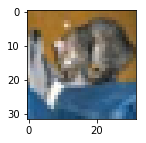

[Prediction] test data1 is ship, artifact, water and bright
[Actual] test data1 is ship, artifact, water and bright


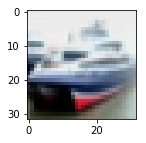

[Prediction] test data2 is ship, artifact, water and dark
[Actual] test data2 is ship, artifact, water and bright


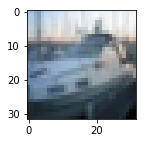

[Prediction] test data3 is airplane, artifact, fly and bright
[Actual] test data3 is airplane, artifact, fly and bright


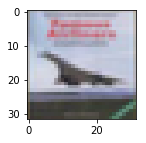

[Prediction] test data4 is frog, animal, water and dark
[Actual] test data4 is frog, animal, water and dark


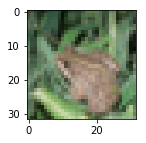

[Prediction] test data5 is frog, animal, water and dark
[Actual] test data5 is frog, animal, water and dark


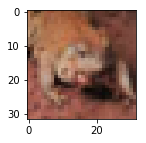

[Prediction] test data6 is automobile, artifact, car and dark
[Actual] test data6 is automobile, artifact, car and dark


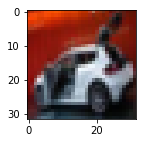

[Prediction] test data7 is frog, animal, water and dark
[Actual] test data7 is frog, animal, water and dark


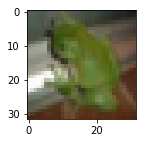

[Prediction] test data8 is cat, animal, mammal and bright
[Actual] test data8 is cat, animal, mammal and bright


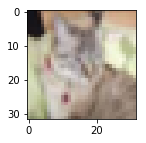

[Prediction] test data9 is automobile, artifact, car and bright
[Actual] test data9 is automobile, artifact, car and bright


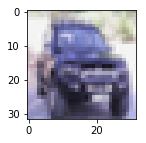

[Prediction] test data10 is airplane, artifact, fly and bright
[Actual] test data10 is airplane, artifact, fly and bright


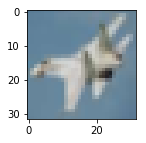

[Prediction] test data11 is truck, artifact, car and dark
[Actual] test data11 is truck, artifact, car and bright


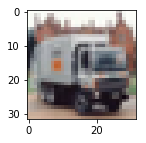

[Prediction] test data12 is dog, animal, mammal and dark
[Actual] test data12 is dog, animal, mammal and dark


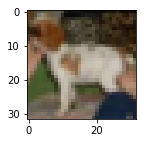

[Prediction] test data13 is horse, animal, mammal and dark
[Actual] test data13 is horse, animal, mammal and dark


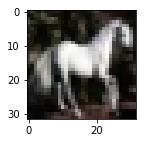

[Prediction] test data14 is truck, artifact, car and dark
[Actual] test data14 is truck, artifact, car and dark


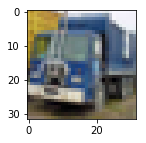

[Prediction] test data15 is frog, animal, water and dark
[Actual] test data15 is ship, artifact, water and dark


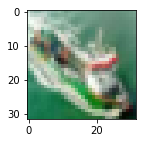

[Prediction] test data16 is dog, animal, mammal and dark
[Actual] test data16 is dog, animal, mammal and bright


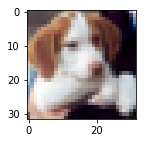

[Prediction] test data17 is horse, animal, mammal and dark
[Actual] test data17 is horse, animal, mammal and bright


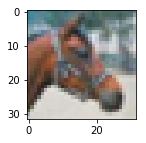

[Prediction] test data18 is ship, artifact, water and bright
[Actual] test data18 is ship, artifact, water and bright


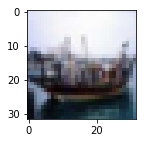

[Prediction] test data19 is frog, animal, water and dark
[Actual] test data19 is frog, animal, water and dark


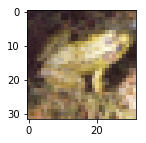

In [77]:
# show image, prediction and actual label
for i in range(20):
    plt.figure(figsize=(2, 2))
    print("[Prediction] test data{0} is {1}, {2}, {3} and {4}".format(
        i,
        label1[np.argmax(prediction[0][i])], 
        label2[np.argmax(prediction[1][i])], 
        label3[np.argmax(prediction[2][i])], 
        label4[np.argmax(prediction[3][i])]))
    print("[Actual] test data{0} is {1}, {2}, {3} and {4}".format(
        i,
        label1[np.argmax(y_test1[i])], 
        label2[np.argmax(y_test2[i])], 
        label3[np.argmax(y_test3[i])],
        label4[np.argmax(y_test4[i])]))
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.show()